In [ ]:
from SynTemp.SynUtils.utils import load_from_pickle, load_database
data = load_database('./Data/DPO/USPTO_50K/test.json.gz')

In [ ]:
hier_temp = load_from_pickle('./Data/DPO/USPTO_50K/Hydrogen/hier_rules.pkl.gz')

In [ ]:
from mod import *
from SynTemp.SynUtils.graph_utils import load_gml_as_text

In [ ]:
initial_molecules = [smiles(smile) for smile in set(['CCCCS(=O)(=O)Cl', 'COc1cc(C(=O)N2Cc3cccn3Cc3ccccc32)ccc1N'])]
gml_content = load_gml_as_text('./Data/DPO/USPTO_50K/Hydrogen/R0/Rules_good/2.gml')
reaction_rule = ruleGMLString(gml_content, invert=False)

In [ ]:
from SynTemp.SynUtils.utils import load_from_pickle, load_database
hier_temp = load_from_pickle('./Data/DPO/USPTO_50K/Good_hydrogen/hier_rules.pkl.gz')
initial_molecules = [smiles(smile) for smile in set(['CCCCS(=O)(=O)Cl', 'COc1cc(C(=O)N2Cc3cccn3Cc3ccccc32)ccc1N'])]

initial_smiles = ['CCCCS(=O)(=O)Cl', 'COc1cc(C(=O)N2Cc3cccn3Cc3ccccc32)ccc1N']
results = HierEngine.hier_rule_apply(initial_smiles=initial_smiles, hier_temp=hier_temp,rule_file_path='./Data/DPO/USPTO_50K/Good_hydrogen')

In [ ]:
bw

In [ ]:
from SynTemp.SynUtils.utils import load_from_pickle, load_database
data = load_database('./Data/DPO/USPTO_50K/test.json.gz')

In [ ]:
from SynTemp.SynRule.rule_benchmark import RuleBenchmark

fw, bw = RuleBenchmark.reproduce_reactions(
        database=data[1:2],
        rule_class_col='R-id',
        rule_file_path='./Data/DPO/USPTO_50K/Good_hydrogen/R0/',
        original_rsmi_col='reactions',
        repeat_times=1,
        use_specific_rules=False,
        verbosity=0,
        job_timeout=5
    )

In [ ]:
len(fw[0]['unrank'])

In [ ]:
len(bw[0]['unrank'])

In [ ]:
from SynTemp.SynRule.rule_benchmark import RuleBenchmark

fw_hier, bw_hier = RuleBenchmark.reproduce_reactions(
        database=data[0:1],
        rule_class_col='R-id',
        rule_file_path='./Data/DPO/USPTO_50K/Good_hydrogen/R0',
        original_rsmi_col='reactions',
        repeat_times=1,
        use_specific_rules=False,
        verbosity=0,
        job_timeout=5,
        hierarchical=True,
        max_radius=3
    )

In [ ]:
if 6 < 5 or 2 > 3 - 1:
    print(1)

In [ ]:
['CNC(=O)OC(C)(C)C.O=[N+]([O-])c1ccc(Cl)c(S(=O)(=O)NCCl)c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)NCl.O=[N+]([O-])c1cccc(S(=O)(=O)NCCCl)c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)Cl.NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)Cl.O=C(O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)O.O=C(Cl)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)NCl.O=[N+]([O-])c1ccc(Cl)c(S(=O)(=O)NCCCl)c1>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(N)=O.O=[N+]([O-])c1ccc(Cl)c(S(=O)(=O)NCCCl)c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)NCCCl.NS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)NCCCl.O=[N+]([O-])c1ccc(Cl)c(S(=O)(=O)NCl)c1>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)NCCN[SH](=O)=O.O=[N+]([O-])c1ccc(Cl)c(Cl)c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.CCl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)Cl.O=[N+]([O-])c1ccc(Cl)c(S(=O)(=O)NCCNCl)c1>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)Cl.O=[N+]([O-])c1cccc(S(=O)(=O)NCCNCl)c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'C.CC(C)(Cl)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)NCCl.CNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)NCCN.O=[N+]([O-])c1ccc(Cl)c(S(=O)(=O)Cl)c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)NCCCl.O=[N+]([O-])c1cccc(S(=O)(=O)NCl)c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl', 'CC(C)(C)OC(=O)NCCNS(=O)O.O=[N+]([O-])c1ccc(Cl)c(Cl)c1Cl>>CC(C)(C)OC(=O)NCCNS(=O)(=O)c1c(Cl)ccc([N+](=O)[O-])c1Cl.Cl']

In [ ]:
len(fw_hier[0]['unrank'])

In [ ]:
len(bw_hier[0]['unrank'])

In [ ]:
bw_hier

In [ ]:
fw_hier

In [ ]:
rule_file_path='./Data/DPO/USPTO_50K/Non_hydrogen/R0'

In [ ]:
temp_results[3]

In [ ]:
len(temp_results)

In [ ]:
temp_results

In [ ]:
# Original list of lists
smiles_lists = [
    ['C1:C:C:C2CN(C3:C(:C:C:C:C:3)CN:1:2)C(C4:C:C:C(:C(:C:4)OC)N)(CCCCS(Cl)(=O)=O)O'],
    ['C1:C:C:C2CN(C3:C(:C:C:C:C:3)CN:1:2)C(C4:C:C:C(:C(:C:4)OC)N)(C(C)CCS(Cl)(=O)=O)O'],
    ['C1:C:C:C2CN(C3:C(:C:C:C:C:3)CN:1:2)C(C4:C:C:C(:C(:C:4)OC)N)(C(CS(Cl)(=O)=O)CC)O'],
    ['C1:C:C:C2CN(C3:C(:C:C:C:C:3)CN:1:2)C(C4:C:C:C(:C(:C:4)OC)C)(C(CCC)S(Cl)(=O)=O)O'],
    ['C1:C:C:C2CN(C3:C(:C:C:C:C:3)CN:1:2)C(C4:C:C:C(:C(:C:4)OC)N)(CCCCS(Cl)(=O)=O)O']  # Duplicate
]

# Convert lists to tuples and store in a set to remove duplicates
unique_smiles_tuples = set(tuple(smiles) for smiles in smiles_lists)

# Convert the set of tuples back into a list of lists
unique_smiles_lists = [list(smiles) for smiles in unique_smiles_tuples]

# Print or return the unique list of lists
print(unique_smiles_lists)


In [ ]:
set([['C1:C:C:C2CN(C3:C(:C:C:C:C:3)CN:1:2)C(C4:C:C:C(:C(:C:4)OC)N)(CCCCS(Cl)(=O)=O)O'], ['C1:C:C:C2CN(C3:C(:C:C:C:C:3)CN:1:2)C(C4:C:C:C(:C(:C:4)OC)N)(C(C)CCS(Cl)(=O)=O)O'], ['C1:C:C:C2CN(C3:C(:C:C:C:C:3)CN:1:2)C(C4:C:C:C(:C(:C:4)OC)N)(C(CS(Cl)(=O)=O)CC)O'], ['C1:C:C:C2CN(C3:C(:C:C:C:C:3)CN:1:2)C(C4:C:C:C(:C(:C:4)OC)N)(C(CCC)S(Cl)(=O)=O)O']])

In [ ]:
hier_rule_apply(initial_molecules, './Data/DPO/USPTO_50K/Hydrogen', hier_temp, radius=0, rule_id = 0)

In [ ]:
hier_temp[0]

In [ ]:
gml_content = load_gml_as_text('./Data/DPO/USPTO_50K/Hydrogen/R1/Rules_good/154.gml')
reaction_rule = ruleGMLString(gml_content, invert=False)

In [ ]:
rule_check(initial_molecules, reaction_rule)

In [ ]:
dg = DG(graphDatabase=initial_molecules)
# dg.build().execute(strategy, verbosity=8)
dg.build().apply(initial_molecules, reaction_rule)

temp_results = []
for e in dg.edges:
    productSmiles = [v.graph.smiles for v in e.targets]
    temp_results.append(productSmiles)

In [ ]:
len(temp_results)

In [ ]:
ground_truth = {'R-id':1, 'ground_truth': "CCO.O=C(OCc1ccccc1)[NH:7][C:6]1([PH:8](=[O:9])[NH:10][C:11](=[O:12])[CH2:13][O:14][c:15]2[cH:16][cH:17][cH:18][cH:19][cH:20]2)[CH2:5][CH2:4][CH2:3][N:2]([NH2:1])[C:21]1=[O:22]>>[NH2:1][N:2]1[CH2:3][CH2:4][CH2:5][C:6]([NH2:7])([PH:8](=[O:9])[NH:10][C:11](=[O:12])[CH2:13][O:14][c:15]2[cH:16][cH:17][cH:18][cH:19][cH:20]2)[C:21]1=[O:22]"}
rxn =  {'R-id':2, 'rxn_mapper': "[CH2:2]([CH3:1])[OH:3].[cH:30]1[cH:29][c:28]([cH:33][cH:32][cH:31]1)[O:27][CH2:26][C:24](=[O:25])[NH:23][P:21](=[O:22])[C:9]2([C:34](=[O:35])[N:5]([NH2:4])[CH2:6][CH2:7][CH2:8]2)[NH:10][C:11](=[O:12])[O:13][CH2:14][c:15]3[cH:16][cH:17][cH:18][cH:19][cH:20]3>>[cH:30]1[cH:29][c:28]([cH:33][cH:32][cH:31]1)[O:27][CH2:26][C:24](=[O:25])[NH:23][P:21]([C:9]2([CH2:8][CH2:7][CH2:6][N:5]([C:34]2=[O:35])[NH2:4])[NH2:10])=[O:22]"}

In [ ]:
from SynTemp.SynITS.its_extraction import ITSExtraction
ground_truth_its = ITSExtraction.process_mapped_smiles(ground_truth, ['ground_truth'])[1]
rxn_its = ITSExtraction.process_mapped_smiles(rxn, ['rxn_mapper'])[1]

In [ ]:
rxn_its

In [ ]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(ground_truth_its['ITSGraph'])

In [ ]:
vis_graph.vis_three_graph(rxn_its['ITSGraph'])

In [29]:
from SynTemp.SynUtils.utils import load_from_pickle
temp = load_from_pickle('Data/DPO/USPTO_50K/Hydrogen/templates.pkl.gz')

In [32]:
temp[0][0]['RC']

{'Cluster_id': 0,
 'RC': (<networkx.classes.graph.Graph at 0x7f5b0e85ab50>,
  <networkx.classes.graph.Graph at 0x7f5b0f97f590>),
 'Parent': []}

In [4]:
cluster = load_from_pickle('./Data/DPO/USPTO_50K/Good_hydrogen/cluster.pkl.gz')

In [21]:
cluster[1]

{'R-id': 27953,
 'ITSGraph': (<networkx.classes.graph.Graph at 0x7f5bf7125bd0>,
  <networkx.classes.graph.Graph at 0x7f5bf7133910>),
 'GraphRules': (<networkx.classes.graph.Graph at 0x7f5bf6f49590>,
  <networkx.classes.graph.Graph at 0x7f5bf6f49e10>),
 'Cluster_R0': 1,
 'Cluster_R1': 55,
 'Cluster_R2': 190,
 'Cluster_R3': 1,
 'Reaction Type': 'Single Cyclic',
 'Rings': [4]}

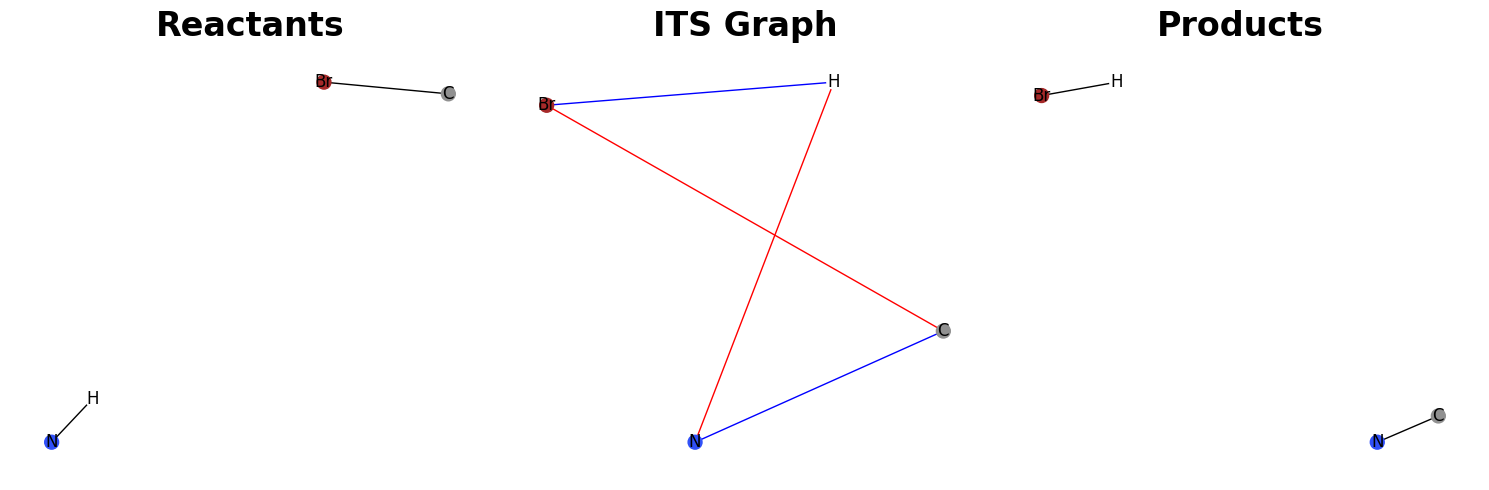

In [34]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(temp[0][0]['RC'])

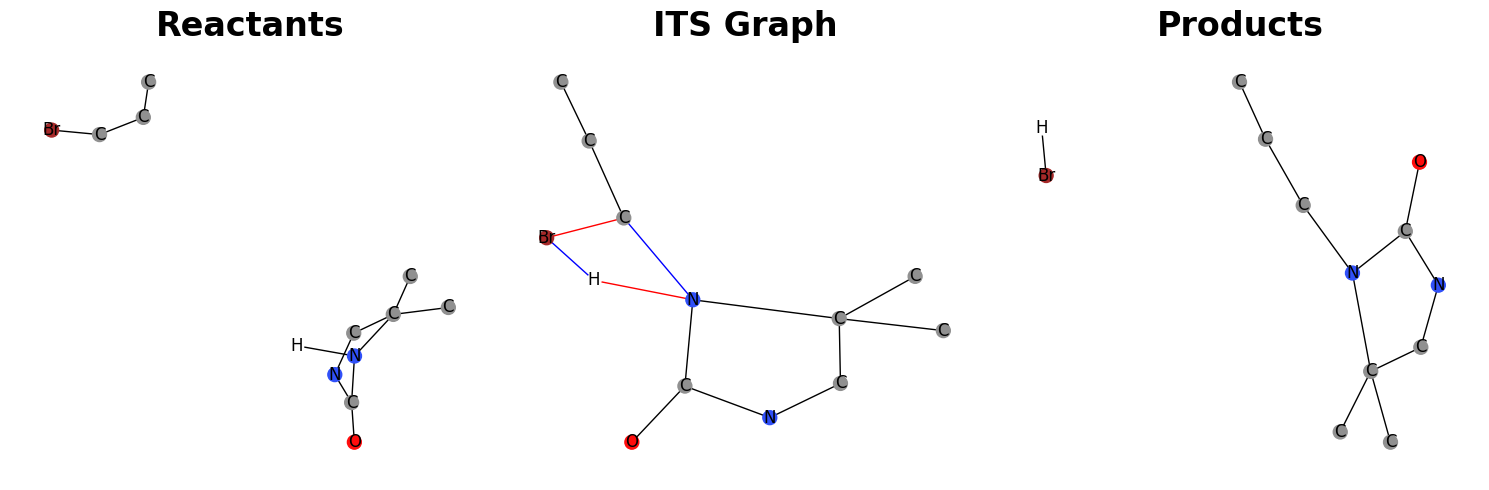

In [36]:
vis_graph.vis_three_graph(temp[2][0]['RC'])

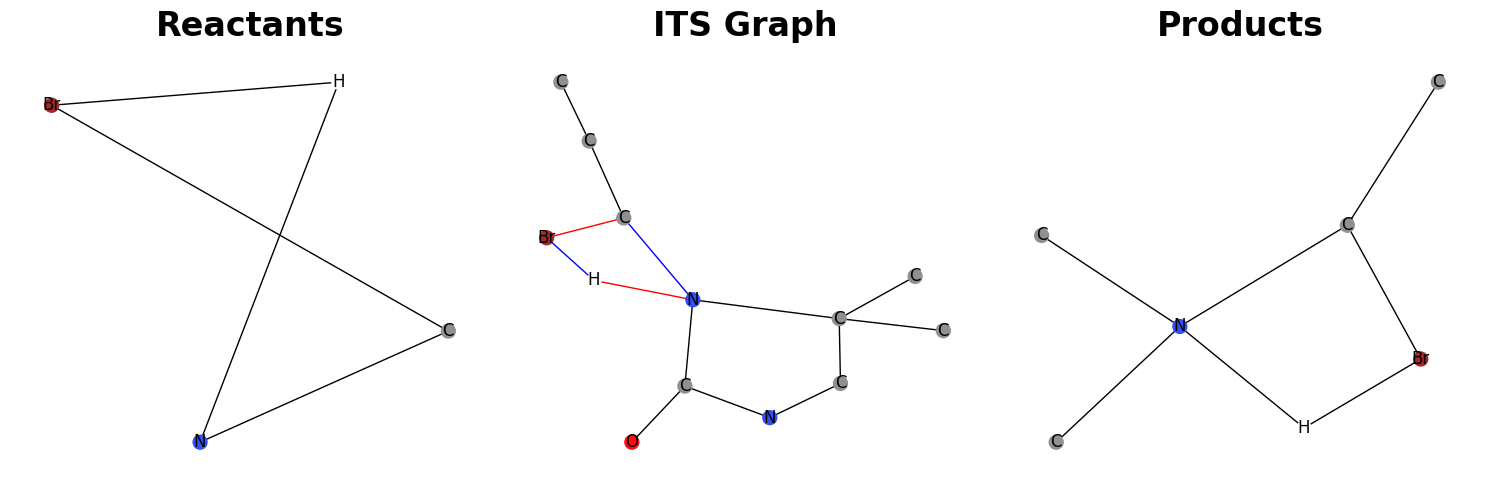

In [16]:
vis_graph.vis_three_graph((temp[0][0]['RC'], temp[1][0]['RC'], temp[2][0]['RC']))

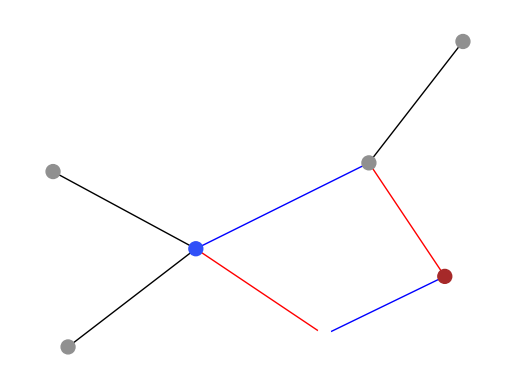

In [19]:
vis_graph.its_vis(temp[1][0]['RC'])

In [47]:
from SynTemp.SynRule.rule_writing import RuleWriting

rules = RuleWriting.auto_extraction(data_dicts=temp[0][0:1], id_column=f'Cluster_id', rule_column = 'RC', reindex=True
                                        #save_path=f'../../Data/DPO/USPTO_50K/{folder_name}/R{i}/'
                                        )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [48]:
print(rules)

['rule [\n   ruleID "0"\n   left [\n      edge [ source 1 target 3 label "-" ]\n      edge [ source 2 target 4 label "-" ]\n   ]\n   context [\n      node [ id 1 label "H" ]\n      node [ id 2 label "C" ]\n      node [ id 3 label "N" ]\n      node [ id 4 label "Br" ]\n   ]\n   right [\n      edge [ source 1 target 4 label "-" ]\n      edge [ source 2 target 3 label "-" ]\n   ]\n]']


In [43]:
temp[0][0:1]

[{'Cluster_id': 0,
  'RC': (<networkx.classes.graph.Graph at 0x7f5b0e85ab50>,
   <networkx.classes.graph.Graph at 0x7f5b0f97f590>),
  'Parent': []}]

In [83]:
from SynTemp.SynUtils.utils import load_database

r0 = load_database('./Data/DPO/USPTO_50K/Hydrogen/Output/fw_good_0.json.gz')[:100]
coverage = 0
total_solution = 0
for value in r0:
    total_solution += len(value['unrank'])
    if value['positive_reactions']:
        coverage += 1

print('Average Solution', total_solution/len(r0))
print('Average coverage', coverage/len(r0))

Average Solution 39.17
Average coverage 0.84


In [98]:
from SynTemp.SynUtils.utils import load_database

fw_hier = load_from_pickle('./fw_hier.pkl.gz')
coverage = 0
total_solution = 0
for value in fw_hier:
    total_solution += len(value['unrank'])
    if value['positive_reactions']:
        coverage += 1

print('Average Solution', total_solution/len(fw_hier))
print('Average coverage', coverage/len(fw_hier))

Average Solution 12.41
Average coverage 0.78


In [95]:
bw_hier = load_from_pickle('./bw_hier.pkl.gz')

In [93]:
0.78/0.84


0.9285714285714286

In [96]:
from SynTemp.SynChemistry.sf_similarity import SFSimilarity
from SynTemp.SynChemistry.sf_maxfrag import SFMaxFrag
from SynTemp.SynRule.rule_benchmark import RuleBenchmark
scoring_functions = {
    'MaxFrag': SFMaxFrag(),
    'ECFP6': SFSimilarity(["ECFP6"]),
    'MACCS': SFSimilarity(["MACCS"]),
    'RDK7': SFSimilarity(["RDK7"])
}

# Benchmarking setup
top_k_values = [1, 3, 5, 10]

In [97]:
for name, func in scoring_functions.items():
    for k in top_k_values:
        accuracy = RuleBenchmark.TopKAccuracy(fw_hier, 'reactions', "ranked_reactions", k, ignore_stero=True, scoring_function=func)
        print(name)
        print(k)
        print(accuracy)
          

MaxFrag
1
5.0


[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not removing hydrogen atom without neighbors
[13:55:01] WARNING: not r

MaxFrag
3
13.0


[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not removing hydrogen atom without neighbors
[13:55:07] WARNING: not r

MaxFrag
5
22.0


[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not removing hydrogen atom without neighbors
[13:55:13] WARNING: not r

MaxFrag
10
35.0


[13:55:19] WARNING: not removing hydrogen atom without neighbors
[13:55:19] WARNING: not removing hydrogen atom without neighbors
[13:55:19] WARNING: not removing hydrogen atom without neighbors
[13:55:19] WARNING: not removing hydrogen atom without neighbors
[13:55:19] WARNING: not removing hydrogen atom without neighbors
[13:55:19] WARNING: not removing hydrogen atom without neighbors


ECFP6
1
7.0


[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not removing hydrogen atom without neighbors
[13:55:20] WARNING: not r

ECFP6
3
20.0


[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not removing hydrogen atom without neighbors
[13:55:22] WARNING: not r

ECFP6
5
33.0


[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not removing hydrogen atom without neighbors
[13:55:23] WARNING: not r

ECFP6
10
46.0


[13:55:25] WARNING: not removing hydrogen atom without neighbors
[13:55:25] WARNING: not removing hydrogen atom without neighbors
[13:55:25] WARNING: not removing hydrogen atom without neighbors
[13:55:25] WARNING: not removing hydrogen atom without neighbors
[13:55:25] WARNING: not removing hydrogen atom without neighbors
[13:55:25] WARNING: not removing hydrogen atom without neighbors


MACCS
1
17.0


[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not removing hydrogen atom without neighbors
[13:55:29] WARNING: not r

MACCS
3
31.0


[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not removing hydrogen atom without neighbors
[13:55:33] WARNING: not r

MACCS
5
38.0


[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not removing hydrogen atom without neighbors
[13:55:37] WARNING: not r

MACCS
10
52.0


[13:55:42] WARNING: not removing hydrogen atom without neighbors
[13:55:42] WARNING: not removing hydrogen atom without neighbors
[13:55:42] WARNING: not removing hydrogen atom without neighbors
[13:55:42] WARNING: not removing hydrogen atom without neighbors
[13:55:42] WARNING: not removing hydrogen atom without neighbors
[13:55:42] WARNING: not removing hydrogen atom without neighbors
[13:55:42] WARNING: not removing hydrogen atom without neighbors
[13:55:42] WARNING: not removing hydrogen atom without neighbors


RDK7
1
7.0


[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not removing hydrogen atom without neighbors
[13:55:46] WARNING: not r

RDK7
3
21.0


[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not removing hydrogen atom without neighbors
[13:55:50] WARNING: not r

RDK7
5
30.0


[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not r

RDK7
10
44.0


[13:55:59] WARNING: not removing hydrogen atom without neighbors
[13:55:59] WARNING: not removing hydrogen atom without neighbors
[13:55:59] WARNING: not removing hydrogen atom without neighbors
[13:55:59] WARNING: not removing hydrogen atom without neighbors
[13:55:59] WARNING: not removing hydrogen atom without neighbors
[13:55:59] WARNING: not removing hydrogen atom without neighbors


In [ ]:
accuracy = RuleBenchmark.TopKAccuracy(bw, args.original_rsmi_col, "ranked_reactions", k, ignore_stero=True, scoring_function=func)

In [73]:
print(len(fw_hier))

100


In [59]:
fw_hier = load_from_pickle('./fw_hier.pkl.gz')

In [51]:
len(r0)

5002

In [53]:
coverage = 0
for value in r0:
    if value['positive_reactions']:
        coverage += 1

In [55]:
coverage/5002

0.7912834866053579

In [ ]:
Result = [['C1(:C:C(:C(:C(:C:1S(Cl)(=O)=O)Cl)[N+]([O-])=O)C(OC(C)(C)C)=NCCN)Cl', 'O'], ['O', 'C1(:C(:C(:C(:C:C:1[N+]([O-])=O)C(OC(C)(C)C)=NCCN)Cl)S(Cl)(=O)=O)Cl']]

Results = [['C1(:C:C(:C(:C(:C:1S(Cl)(=O)=O)Cl)[N+]([O-])=O)C(OC(C)(C)C)=NCCN)Cl', 'O'], ['O', 'C1(:C(:C(:C(:C:C:1[N+]([O-])=O)C(OC(C)(C)C)=NCCN)Cl)S(Cl)(=O)=O)Cl']]


In [74]:
if [[]]:
    print(1)

1
